<h1><center><font size="6">Fraudulent Click Prediction in Online Advertising</font></center></h1>

# <a id='0'>Content</a>

- <a href='#1'>Load packages</a>  
- <a href='#2'>Parameters</a>  
- <a href='#3'>Read the data</a>  
- <a href='#4'>Check the data</a>   
    - <a href='#41'>Check missing data</a>
    - <a href='#42'>Check data unbalance</a>
- <a href='#5'>Data exploration</a>
- <a href='#6'>Data engineering</a>
    - <a href='#61'>Extract date and time data</a>
    - <a href='#62'>Additional data engineering</a>    
    - <a href='#63'>Data unbalance between train and test data</a>
- <a href='#7'>Model</a>  
    - <a href='#71'>Prepare the model</a>  
    - <a href='#72'>Train the model</a> 
    - <a href='#73'>Prediction</a>
- <a href='#8'>Testing</a>  


# <a id="1">Load packages</a>

Here we load the libraries and set few parameters.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.impute import SimpleImputer 
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler

from lightgbm import LGBMClassifier

import lightgbm as lgb
import gc # memory 
from datetime import datetime # train time checking

from sklearn.metrics import confusion_matrix, f1_score, roc_auc_score

pd.set_option('display.max_columns', 100)

## <a id="2">Parameters</a>

Here we set most of the parameters used in this Notebook.



In [2]:
#VALIDATION
VALIDATE = False  #validation using train_test_split
VALID_SIZE = 0.90 # simple validation using train_test_split

#CROSS-VALIDATION
VALIDATE_KFOLDS = True #cross-validation using KFolds
NUMBER_KFOLDS = 5 #number of KFolds for cross-validation

SAMPLE = True    #True: use train.sample (100,000 rows) False: use full training set (train)
RANDOM_STATE = 2018

MAX_ROUNDS = 1000 #lgb iterations
EARLY_STOP = 50  #lgb early stop 
OPT_ROUNDS = 650  #To be adjusted based on best validation rounds
skiprows = range(1,109903891) #
nrows = 75000000
#USE SAMPLE FROM FULL TRAIN SET
SAMPLE_SIZE = 1 # use a subsample of the train set

PATH = 'dataset/'
print(os.listdir(PATH))

['clickfraud.csv']


# <a id="3">Read the data</a>

We read the data with the options set in the **Parameters** section.


In [3]:
dtypes = {
        'ip'            : 'uint32',
        'app'           : 'uint16',
        'device'        : 'uint16',
        'os'            : 'uint16',
        'channel'       : 'uint16',
        'is_attributed' : 'uint8',
        }

train_cols = ['ip','app','device','os', 'channel', 'click_time', 'is_attributed']
dataset = pd.read_csv(PATH+"clickfraud.csv", dtype=dtypes, usecols=train_cols)

In [4]:
trainset = dataset.loc[:1000000-1].copy()
testset = dataset.loc[1000000:].copy()

# <a id="4">Check the data</a>
Let's check the train and test set structure.


In [5]:
print("train -  rows:",trainset.shape[0]," columns:", trainset.shape[1])
print("test -  rows:",testset.shape[0]," columns:", testset.shape[1])


train -  rows: 1000000  columns: 7
test -  rows: 441685  columns: 7


In [6]:
trainset.head()


,channel,os,device,app,ip,click_time,is_attributed
0,280,16,1,3,90717,2017-11-07 01:43:37,0
1,215,13,1,9,113867,2017-11-07 01:43:37,0
2,489,13,1,14,125396,2017-11-07 01:43:37,0
3,379,20,1,3,34779,2017-11-07 01:43:37,0
4,442,13,1,14,134288,2017-11-07 01:43:37,0


In [7]:
testset.head()

,channel,os,device,app,ip,click_time,is_attributed
1000000,19,19,1,12,61861,2017-11-07 02:02:30,0
1000001,459,25,1,64,31866,2017-11-07 02:02:30,0
1000002,477,17,1,2,17204,2017-11-07 02:02:30,0
1000003,469,19,1,11,115673,2017-11-07 02:02:30,0
1000004,5,19,1,45,40631,2017-11-07 02:02:30,1


The trainset columns are:
* **ip**: ip address of click (numeric);
* **app**: app id for marketing (category);
* **device**: device type id of user mobile phone (e.g., iphone 6 plus, iphone 7, huawei mate 7, etc.) (category);
* **os**: os version id of user mobile phone (category);
* **channel**: channel id of mobile ad publisher (category);
* **click_time**: timestamp of click (UTC) (time);
* **is_attributed**: the target that is to be predicted, indicating the app was downloaded (binary);

## <a id="41">Check missing data</a>

Let's check missing data in train and test.


In [8]:
def missing_data(data):
    total = data.isnull().sum().sort_values(ascending = False)
    percent = (data.isnull().sum()/data.isnull().count()*100).sort_values(ascending = False)
    return pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])

Train data:

In [9]:
missing_data(trainset)

,Total,Percent
channel,0,0.0
os,0,0.0
device,0,0.0
app,0,0.0
ip,0,0.0
click_time,0,0.0
is_attributed,0,0.0


Test data:

In [10]:
missing_data(testset)

,Total,Percent
channel,0,0.0
os,0,0.0
device,0,0.0
app,0,0.0
ip,0,0.0
click_time,0,0.0
is_attributed,0,0.0


## <a id="42">Check data unbalance</a>

We will check the **target** (**is_attributed**) data unbalance. 

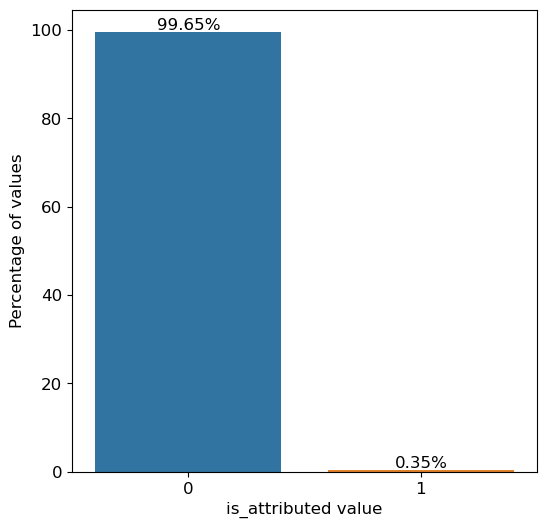

In [11]:
plt.figure(figsize=(6, 6))
ax = plt.gca()

# Calculate percentage values
total = len(trainset)
percentages = trainset['is_attributed'].value_counts(normalize=True) * 100

# Bar plot
sns.barplot(ax=ax, x=percentages.index, y=percentages.values)

# Annotate each bar with its percentage value
for i, value in enumerate(percentages.values):
    plt.text(i, value + 0.5, f'{value:.2f}%', ha='center', fontsize=12)

plt.ylabel('Percentage of values', fontsize=12)
plt.xlabel('is_attributed value', fontsize=12)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.show()


Only a very small part of the **is_attributed** data have 1 value (0.35%). This means that the training dataset is highly imbalanced . Usually either we undersample the records with **is_attributed** = 0 or oversample records with **is_attributed** = 1. Because is a large dataset, it is a good option to do undersampling of records with **is_attributed** = 0.

In [12]:
X_train = trainset.drop(columns=['is_attributed'])  # Features
y_train = trainset['is_attributed']  # Target variable

# Instantiate the RandomUnderSampler
rus = RandomUnderSampler(random_state=42)

# Undersample the majority class
X_train_resampled, y_train_resampled = rus.fit_resample(X_train, y_train)

trainset = X_train_resampled.copy()
trainset['is_attributed'] = y_train_resampled

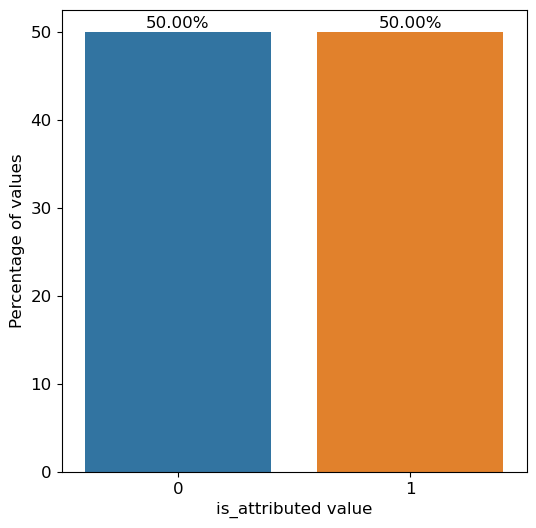

In [13]:
plt.figure(figsize=(6, 6))
ax = plt.gca()

# Calculate percentage values
total = len(trainset)
percentages = trainset['is_attributed'].value_counts(normalize=True) * 100

# Bar plot
sns.barplot(ax=ax, x=percentages.index, y=percentages.values)

# Annotate each bar with its percentage value
for i, value in enumerate(percentages.values):
    plt.text(i, value + 0.5, f'{value:.2f}%', ha='center', fontsize=12)

plt.ylabel('Percentage of values', fontsize=12)
plt.xlabel('is_attributed value', fontsize=12)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.show()

# <a id="5">Data exploration</a>

In [14]:
trainset.describe()

,channel,os,device,app,ip,is_attributed
count,6906.000000,6906.000000,6906.000000,6906.000000,6906.000000,6906.000000
mean,214.422821,22.736027,25.277440,21.030988,100857.894440,0.500000
std,132.633746,49.413363,241.412932,23.516951,60882.388082,0.500036
min,0.000000,0.000000,0.000000,0.000000,36.000000,0.000000
25%,113.000000,13.000000,1.000000,8.000000,47405.500000,0.000000
50%,213.000000,19.000000,1.000000,15.000000,98397.000000,0.500000
75%,280.000000,21.000000,1.000000,35.000000,151313.750000,1.000000
max,497.000000,607.000000,3346.000000,481.000000,212770.000000,1.000000


We can observe that, while ip is a number with a wide range of values, **app**, **device**, **os** and **channel** are categorical values with a smaller range of variation. Let's separate between values with **is_attributed** with value `1` and value `0`.

In [15]:
t1 = trainset.loc[trainset['is_attributed'] != 0.]
t0 = trainset.loc[trainset['is_attributed'] == 0.]

t0.describe()

,channel,os,device,app,ip,is_attributed
count,3453.000000,3453.000000,3453.000000,3453.000000,3453.000000,3453.0
mean,266.136403,24.699971,34.424269,12.011584,88000.922676,0.0
std,126.201343,63.702313,314.596223,16.393654,56545.146980,0.0
min,3.000000,0.000000,0.000000,1.000000,36.000000,0.0
25%,145.000000,13.000000,1.000000,3.000000,40317.000000,0.0
50%,259.000000,18.000000,1.000000,12.000000,82856.000000,0.0
75%,379.000000,19.000000,1.000000,15.000000,123843.000000,0.0
max,497.000000,607.000000,3032.000000,481.000000,212770.000000,0.0


In [16]:
t1.describe()

,channel,os,device,app,ip,is_attributed
count,3453.000000,3453.000000,3453.000000,3453.000000,3453.000000,3453.0
mean,162.709238,20.772082,16.130611,30.050391,113714.866203,1.0
std,117.947445,28.607118,132.057295,25.976063,62340.606879,0.0
min,0.000000,0.000000,0.000000,0.000000,59.000000,1.0
25%,21.000000,13.000000,1.000000,15.000000,59245.000000,1.0
50%,140.000000,19.000000,1.000000,35.000000,121025.000000,1.0
75%,268.000000,24.000000,1.000000,35.000000,168212.000000,1.0
max,489.000000,607.000000,3346.000000,481.000000,212749.000000,1.0


We can observe that in the two sets, **ip** and **os** and **channel** have values in the same ranges for both **is_attributed** values (0 and 1). Maximum values for **app** is almost double and maximum value for **device** is four times larger for **is_attributed** = 0.

Let's visualize the distribution of values of **app**, **device**, **os** and **channel**, grouped on **is_attributed**.

<Figure size 640x480 with 0 Axes>

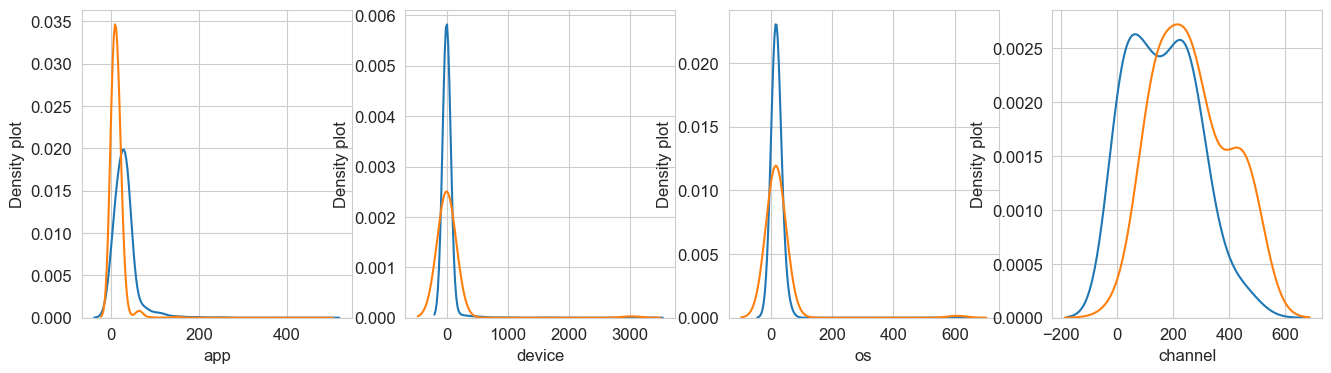

In [17]:
var = ['app','device','os','channel']

i = 0
t1 = trainset.loc[trainset['is_attributed'] != 0]
t0 = trainset.loc[trainset['is_attributed'] == 0]

sns.set_style('whitegrid')
plt.figure()
fig, ax = plt.subplots(1,4,figsize=(16,4))

for feature in var:
    i += 1
    plt.subplot(1,4,i)
    sns.kdeplot(t1[feature], bw_method=0.5,label="is_attributed = 1")
    sns.kdeplot(t0[feature], bw_method=0.5,label="is_attributed = 0")
    plt.ylabel('Density plot', fontsize=12)
    plt.xlabel(feature, fontsize=12)
    locs, labels = plt.xticks()
    plt.tick_params(axis='both', which='major', labelsize=12)
plt.show();

# <a id="6">Data engineering<a/>

## <a id="61">Extract date and time data</a>

In [18]:
trainset['year'] = pd.to_datetime(trainset.click_time).dt.year
trainset['month'] = pd.to_datetime(trainset.click_time).dt.month
trainset['day'] = pd.to_datetime(trainset.click_time).dt.day
trainset['hour'] = pd.to_datetime(trainset.click_time).dt.hour
trainset['min'] = pd.to_datetime(trainset.click_time).dt.minute
trainset['sec'] = pd.to_datetime(trainset.click_time).dt.second
trainset.head()

,channel,os,device,app,ip,click_time,is_attributed,year,month,day,hour,min,sec
519267,424,12,1,3,105162,2017-11-07 01:53:28,0,2017,11,7,1,53,28
830237,130,37,1,15,168332,2017-11-07 01:59:22,0,2017,11,7,1,59,22
906152,265,30,1,12,5314,2017-11-07 02:00:43,0,2017,11,7,2,0,43
229006,130,19,1,15,81245,2017-11-07 01:47:50,0,2017,11,7,1,47,50
270952,237,43,1,2,147957,2017-11-07 01:48:38,0,2017,11,7,1,48,38


In [19]:
trainset.describe()

,channel,os,device,app,ip,is_attributed,year,month,day,hour,min,sec
count,6906.000000,6906.000000,6906.000000,6906.000000,6906.000000,6906.000000,6906.0,6906.0,6906.0,6906.000000,6906.000000,6906.000000
mean,214.422821,22.736027,25.277440,21.030988,100857.894440,0.500000,2017.0,11.0,7.0,1.132493,44.683174,29.417463
std,132.633746,49.413363,241.412932,23.516951,60882.388082,0.500036,0.0,0.0,0.0,0.339051,17.718087,17.335090
min,0.000000,0.000000,0.000000,0.000000,36.000000,0.000000,2017.0,11.0,7.0,1.000000,0.000000,0.000000
25%,113.000000,13.000000,1.000000,8.000000,47405.500000,0.000000,2017.0,11.0,7.0,1.000000,45.000000,15.000000
50%,213.000000,19.000000,1.000000,15.000000,98397.000000,0.500000,2017.0,11.0,7.0,1.000000,50.000000,29.000000
75%,280.000000,21.000000,1.000000,35.000000,151313.750000,1.000000,2017.0,11.0,7.0,1.000000,55.000000,44.000000
max,497.000000,607.000000,3346.000000,481.000000,212770.000000,1.000000,2017.0,11.0,7.0,2.000000,59.000000,59.000000


<Figure size 640x480 with 0 Axes>

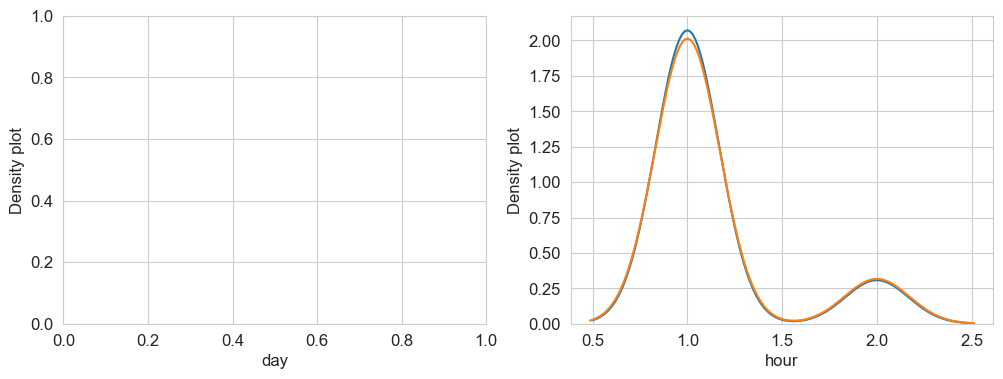

In [20]:
var = ['day','hour']

i = 0
t1 = trainset.loc[trainset['is_attributed'] != 0]
t0 = trainset.loc[trainset['is_attributed'] == 0]

sns.set_style('whitegrid')
plt.figure()
fig, ax = plt.subplots(1,2,figsize=(12,4))

for feature in var:
    i += 1
    plt.subplot(1,2,i)
    sns.kdeplot(t1[feature], bw_method=0.5,label="is_attributed = 1", warn_singular=False)
    sns.kdeplot(t0[feature], bw_method=0.5,label="is_attributed = 0", warn_singular=False)
    plt.ylabel('Density plot', fontsize=12)
    plt.xlabel(feature, fontsize=12)
    locs, labels = plt.xticks()
    plt.tick_params(axis='both', which='major', labelsize=12)
plt.show();

Let's represent the hour distribution with an alternative method, using barplots to show percent from all data of the **true** data.

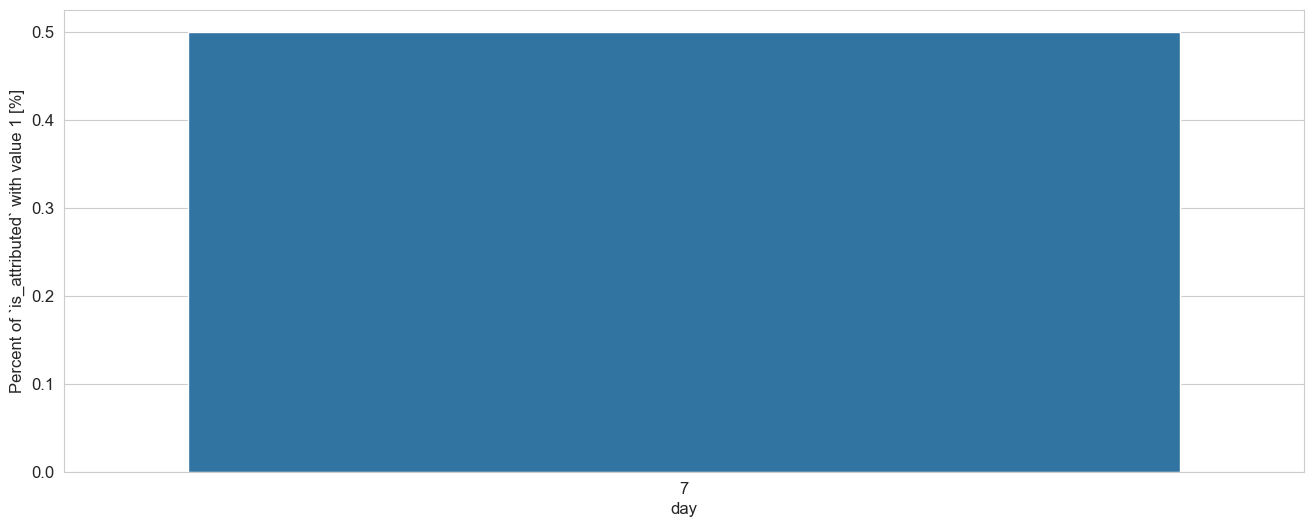

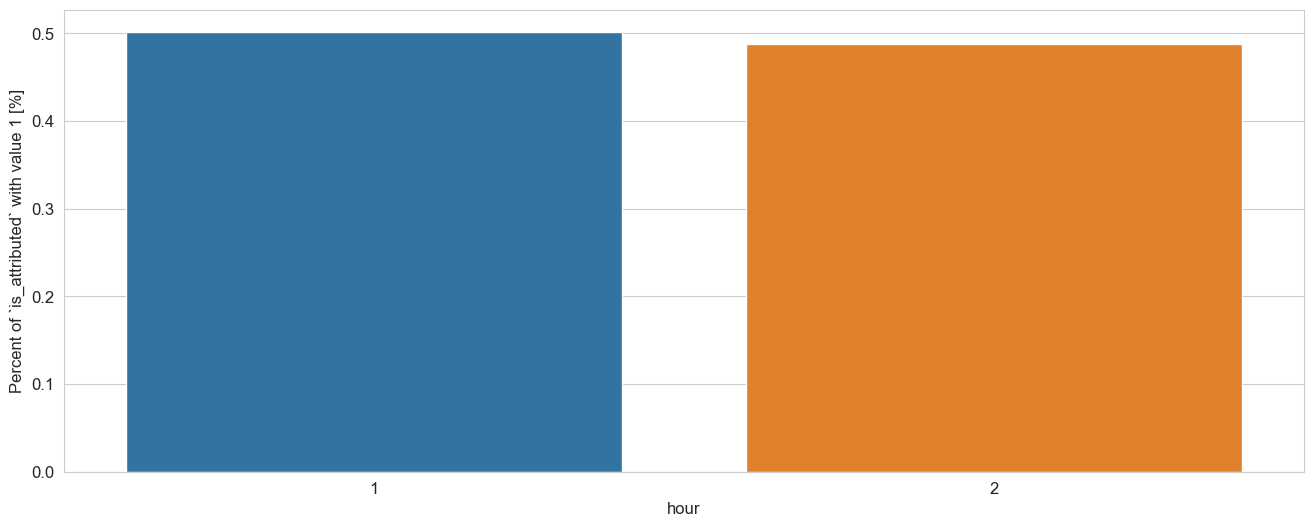

In [21]:
var = ['day','hour']

for feature in var:
    fig, ax = plt.subplots(figsize=(16,6))
    # Calculate the percentage of target=1 per category value
    cat_perc = trainset[[feature, 'is_attributed']].groupby([feature],as_index=False).mean()
    cat_perc.sort_values(by='is_attributed', ascending=False, inplace=True)
    # Bar plot
    #sns.barplot(ax=ax,x=feature, y='is_attributed', data=cat_perc, order=cat_perc[feature]) #for ordered bars
    sns.barplot(ax=ax,x=feature, y='is_attributed', data=cat_perc)
    plt.ylabel('Percent of `is_attributed` with value 1 [%]', fontsize=12)
    plt.xlabel(feature, fontsize=12)
    plt.tick_params(axis='both', which='major', labelsize=12)
    plt.show();

## <a id="62">Additional feature engineering</a>

Define several functions for calculation of derived features.

In [22]:
#------------------------------------------------------------------------------
def show_max_clean(df,gp,agg_name,agg_type,show_max):
#------------------------------------------------------------------------------    
    del gp
    if show_max:
        print( agg_name + " max value = ", df[agg_name].max() )
    df[agg_name] = df[agg_name].astype(agg_type)
    gc.collect()
    return( df )
    
#------------------------------------------------------------------------------
def perform_count( df, group_cols, agg_name, agg_type='uint32', show_max=False, show_agg=True ):
#------------------------------------------------------------------------------
    if show_agg:
        print( "Aggregating by ", group_cols , '...' )
    gp = df[group_cols][group_cols].groupby(group_cols).size().rename(agg_name).to_frame().reset_index()
    df = df.merge(gp, on=group_cols, how='left')
    return (show_max_clean(df,gp,agg_name,agg_type,show_max))

#------------------------------------------------------------------------------
def perform_countuniq( df, group_cols, counted, agg_name, agg_type='uint32', show_max=False, show_agg=True ):
#------------------------------------------------------------------------------    
    if show_agg:
        print( "Counting unique ", counted, " by ", group_cols , '...' )
    gp = df[group_cols+[counted]].groupby(group_cols)[counted].nunique().reset_index().rename(columns={counted:agg_name})
    df = df.merge(gp, on=group_cols, how='left')
    return (show_max_clean(df,gp,agg_name,agg_type,show_max))

#------------------------------------------------------------------------------    
def perform_cumcount( df, group_cols, counted, agg_name, agg_type='uint32', show_max=False, show_agg=True ):
#------------------------------------------------------------------------------    
    if show_agg:
        print( "Cumulative count by ", group_cols , '...' )
    gp = df[group_cols+[counted]].groupby(group_cols)[counted].cumcount()
    df[agg_name]=gp.values
    return (show_max_clean(df,gp,agg_name,agg_type,show_max))

#------------------------------------------------------------------------------
def perform_mean( df, group_cols, counted, agg_name, agg_type='float32', show_max=False, show_agg=True ):
#------------------------------------------------------------------------------    
    if show_agg:
        print( "Calculating mean of ", counted, " by ", group_cols , '...' )
    gp = df[group_cols+[counted]].groupby(group_cols)[counted].mean().reset_index().rename(columns={counted:agg_name})
    df = df.merge(gp, on=group_cols, how='left')
    return (show_max_clean(df,gp,agg_name,agg_type,show_max))

#------------------------------------------------------------------------------
def perform_var( df, group_cols, counted, agg_name, agg_type='float32', show_max=False, show_agg=True ):
#------------------------------------------------------------------------------    
    if show_agg:
        print( "Calculating variance of ", counted, " by ", group_cols , '...' )
    gp = df[group_cols+[counted]].groupby(group_cols)[counted].var().reset_index().rename(columns={counted:agg_name})
    df = df.merge(gp, on=group_cols, how='left')
    return (show_max_clean(df,gp,agg_name,agg_type,show_max))

Now we call the routines for additional features calculation.

In [23]:
trainset = perform_countuniq( trainset, ['ip'], 'channel', 'X0', 'uint8', show_max=True ); gc.collect()
trainset = perform_cumcount( trainset, ['ip', 'device', 'os'], 'app', 'X1', show_max=True ); gc.collect()
trainset = perform_countuniq( trainset, ['ip', 'day'], 'hour', 'X2', 'uint8', show_max=True ); gc.collect()
trainset = perform_countuniq( trainset, ['ip'], 'app', 'X3', 'uint8', show_max=True ); gc.collect()
trainset = perform_countuniq( trainset, ['ip', 'app'], 'os', 'X4', 'uint8', show_max=True ); gc.collect()
trainset = perform_countuniq( trainset, ['ip'], 'device', 'X5', 'uint16', show_max=True ); gc.collect()
trainset = perform_countuniq( trainset, ['app'], 'channel', 'X6', show_max=True ); gc.collect()
trainset = perform_cumcount( trainset, ['ip'], 'os', 'X7', show_max=True ); gc.collect()
trainset = perform_countuniq( trainset, ['ip', 'device', 'os'], 'app', 'X8', show_max=True ); gc.collect()
trainset = perform_count( trainset, ['ip', 'day', 'hour'], 'ip_tcount', show_max=True ); gc.collect()
trainset = perform_count( trainset, ['ip', 'app'], 'ip_app_count', show_max=True ); gc.collect()
trainset = perform_count( trainset, ['ip', 'app', 'os'], 'ip_app_os_count', 'uint16', show_max=True ); gc.collect()
trainset = perform_var( trainset, ['ip', 'day', 'channel'], 'hour', 'ip_tchan_count', show_max=True ); gc.collect()
trainset = perform_var( trainset, ['ip', 'app', 'os'], 'hour', 'ip_app_os_var', show_max=True ); gc.collect()
trainset = perform_var( trainset, ['ip', 'app', 'channel'], 'day', 'ip_app_channel_var_day', show_max=True ); gc.collect()
trainset = perform_mean( trainset, ['ip', 'app', 'channel'], 'hour', 'ip_app_channel_mean_hour', show_max=True ); gc.collect()

Counting unique  channel  by  ['ip'] ...
X0 max value =  15
Cumulative count by  ['ip', 'device', 'os'] ...
X1 max value =  5
Counting unique  hour  by  ['ip', 'day'] ...
X2 max value =  2
Counting unique  app  by  ['ip'] ...
X3 max value =  11
Counting unique  os  by  ['ip', 'app'] ...
X4 max value =  5
Counting unique  device  by  ['ip'] ...
X5 max value =  4
Counting unique  channel  by  ['app'] ...
X6 max value =  24
Cumulative count by  ['ip'] ...
X7 max value =  18
Counting unique  app  by  ['ip', 'device', 'os'] ...
X8 max value =  6
Aggregating by  ['ip', 'day', 'hour'] ...
ip_tcount max value =  16
Aggregating by  ['ip', 'app'] ...
ip_app_count max value =  6
Aggregating by  ['ip', 'app', 'os'] ...
ip_app_os_count max value =  2
Calculating variance of  hour  by  ['ip', 'day', 'channel'] ...
ip_tchan_count max value =  0.5
Calculating variance of  hour  by  ['ip', 'app', 'os'] ...
ip_app_os_var max value =  0.5
Calculating variance of  day  by  ['ip', 'app', 'channel'] ...
ip_

0

In [24]:
trainset.head(5)

,channel,os,device,app,ip,click_time,is_attributed,year,month,day,hour,min,sec,X0,X1,X2,X3,X4,X5,X6,X7,X8,ip_tcount,ip_app_count,ip_app_os_count,ip_tchan_count,ip_app_os_var,ip_app_channel_var_day,ip_app_channel_mean_hour
0,424,12,1,3,105162,2017-11-07 01:53:28,0,2017,11,7,1,53,28,3,0,1,3,1,1,24,0,2,3,1,1,NaN,NaN,NaN,1.0
1,130,37,1,15,168332,2017-11-07 01:59:22,0,2017,11,7,1,59,22,1,0,1,1,1,1,16,0,1,1,1,1,NaN,NaN,NaN,1.0
2,265,30,1,12,5314,2017-11-07 02:00:43,0,2017,11,7,2,0,43,15,0,2,11,2,3,23,0,1,2,2,1,NaN,NaN,NaN,2.0
3,130,19,1,15,81245,2017-11-07 01:47:50,0,2017,11,7,1,47,50,1,0,1,1,1,1,16,0,1,1,1,1,NaN,NaN,NaN,1.0
4,237,43,1,2,147957,2017-11-07 01:48:38,0,2017,11,7,1,48,38,6,0,1,5,1,3,17,0,1,6,1,1,NaN,NaN,NaN,1.0


<Figure size 640x480 with 0 Axes>

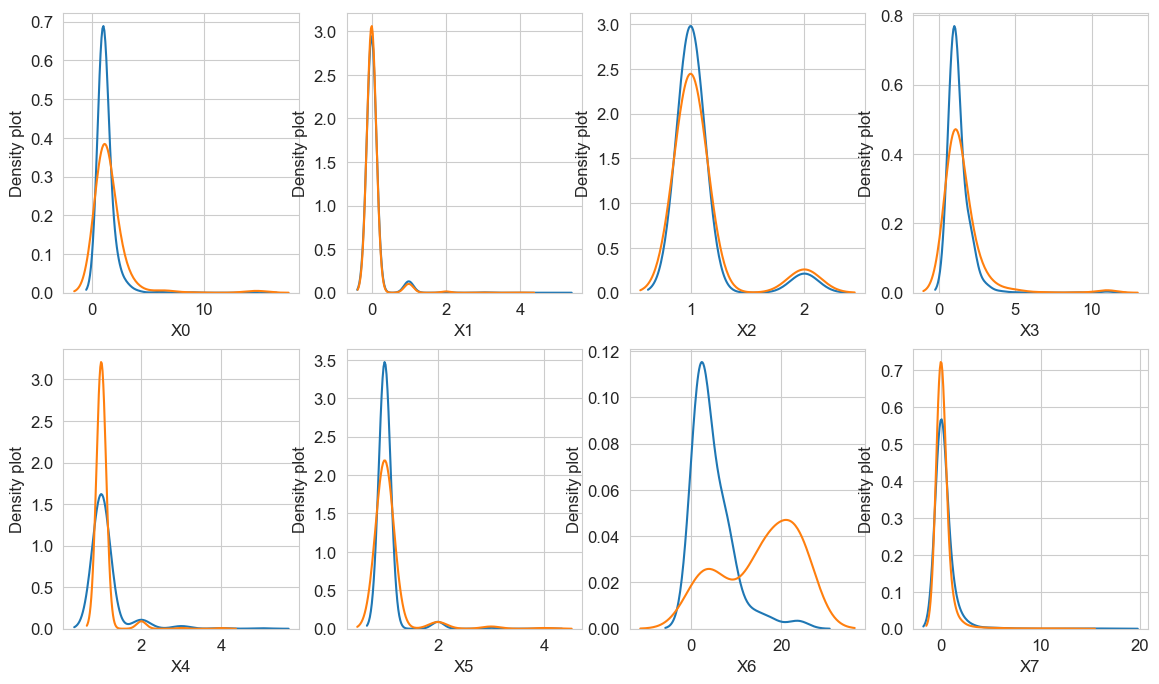

In [25]:
var = ['X0','X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7']

i = 0
t1 = trainset.loc[trainset['is_attributed'] != 0]
t0 = trainset.loc[trainset['is_attributed'] == 0]

sns.set_style('whitegrid')
plt.figure()
fig, ax = plt.subplots(2,4,figsize=(14,8))

for feature in var:
    i += 1
    plt.subplot(2,4,i)
    sns.kdeplot(t1[feature], bw_method=0.5,label="is_attributed = 1")
    sns.kdeplot(t0[feature], bw_method=0.5,label="is_attributed = 0")
    plt.ylabel('Density plot', fontsize=12)
    plt.xlabel(feature, fontsize=12)
    locs, labels = plt.xticks()
    plt.tick_params(axis='both', which='major', labelsize=12)
plt.show();

<Figure size 640x480 with 0 Axes>

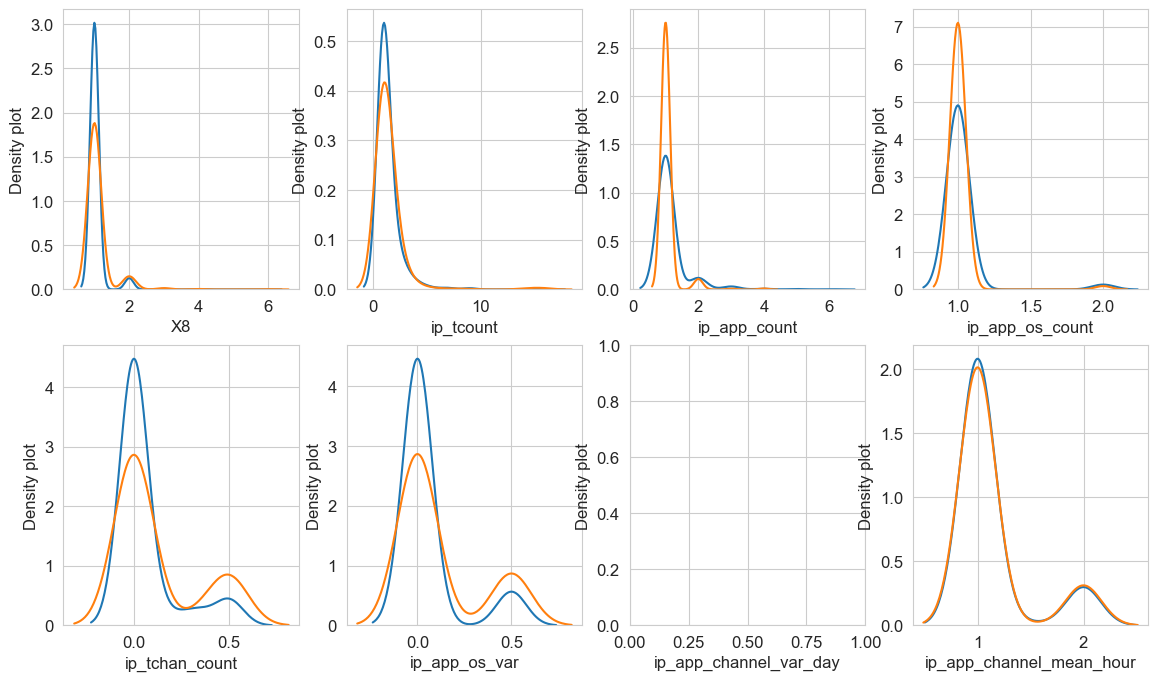

In [26]:
var = ['X8', 'ip_tcount', 'ip_app_count','ip_app_os_count', 
        'ip_tchan_count','ip_app_os_var','ip_app_channel_var_day', 'ip_app_channel_mean_hour']

i = 0
t1 = trainset.loc[trainset['is_attributed'] != 0]
t0 = trainset.loc[trainset['is_attributed'] == 0]

sns.set_style('whitegrid')
plt.figure()
fig, ax = plt.subplots(2,4,figsize=(14,8))

for feature in var:
    i += 1
    plt.subplot(2,4,i)
    sns.kdeplot(t1[feature], bw_method=0.5,label="is_attributed = 1", warn_singular=False)
    sns.kdeplot(t0[feature], bw_method=0.5,label="is_attributed = 0", warn_singular=False)
    plt.ylabel('Density plot', fontsize=12)
    plt.xlabel(feature, fontsize=12)
    locs, labels = plt.xticks()
    plt.tick_params(axis='both', which='major', labelsize=12)
plt.show();

## <a id="63">Data unbalance between train and test data</a>

Let's compare the distribution of the features in the train and test datasets.
Let's start with the data about application, devide, operating system and channel.

<Figure size 640x480 with 0 Axes>

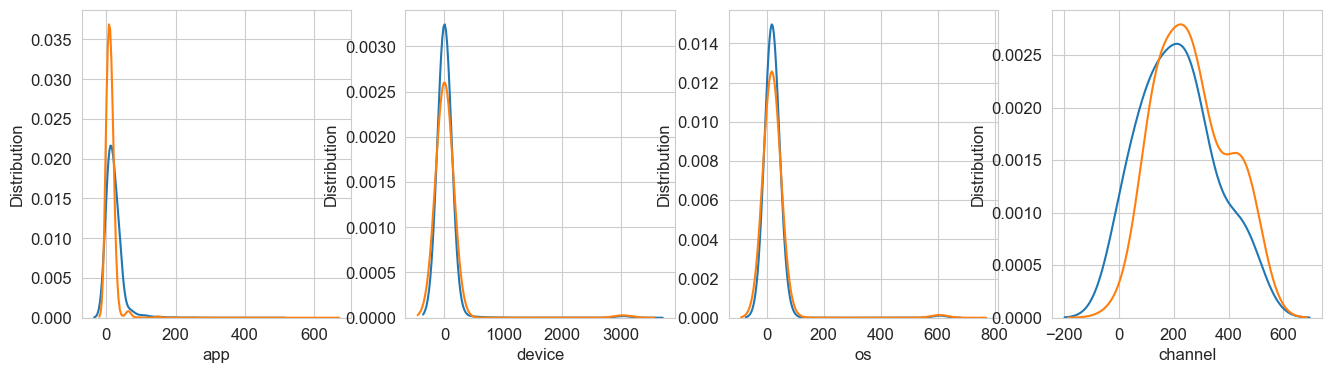

In [27]:
var = ['app','device','os','channel']

# Bar plot
sns.set_style('whitegrid')

plt.figure()
fig, ax = plt.subplots(1,4,figsize=(16,4))
i = 0
for feature in var:
    i = i + 1
    plt.subplot(1,4,i)
    sns.kdeplot(trainset[feature], bw_method=0.5, label="train")
    sns.kdeplot(testset[feature], bw_method=0.5, label="test")
    plt.ylabel('Distribution', fontsize=12)
    plt.xlabel(feature, fontsize=12)
    locs, labels = plt.xticks()
    #plt.setp(labels, rotation=90)
    plt.tick_params(axis='both', which='major', labelsize=12)
plt.show();

Let's continue with the data on time. First we will have to do the date and time extraction operation on testset data.

In [28]:
testset['year'] = pd.to_datetime(testset.click_time).dt.year
testset['month'] = pd.to_datetime(testset.click_time).dt.month
testset['day'] = pd.to_datetime(testset.click_time).dt.day
testset['hour'] = pd.to_datetime(testset.click_time).dt.hour
testset['min'] = pd.to_datetime(testset.click_time).dt.minute
testset['sec'] = pd.to_datetime(testset.click_time).dt.second
testset.head()

,channel,os,device,app,ip,click_time,is_attributed,year,month,day,hour,min,sec
1000000,19,19,1,12,61861,2017-11-07 02:02:30,0,2017,11,7,2,2,30
1000001,459,25,1,64,31866,2017-11-07 02:02:30,0,2017,11,7,2,2,30
1000002,477,17,1,2,17204,2017-11-07 02:02:30,0,2017,11,7,2,2,30
1000003,469,19,1,11,115673,2017-11-07 02:02:30,0,2017,11,7,2,2,30
1000004,5,19,1,45,40631,2017-11-07 02:02:30,1,2017,11,7,2,2,30


In [29]:
testset.describe()

,channel,os,device,app,ip,is_attributed,year,month,day,hour,min,sec
count,441685.000000,441685.000000,441685.000000,441685.000000,441685.000000,441685.000000,441685.0,441685.0,441685.0,441685.0,441685.000000,441685.000000
mean,266.328737,24.074977,31.946075,11.635229,87695.424708,0.003654,2017.0,11.0,7.0,2.0,6.210234,30.098351
std,124.526146,60.328703,303.271469,14.267955,56256.253675,0.060339,0.0,0.0,0.0,0.0,2.441584,16.997967
min,0.000000,0.000000,0.000000,1.000000,9.000000,0.000000,2017.0,11.0,7.0,2.0,2.000000,0.000000
25%,153.000000,13.000000,1.000000,3.000000,41369.000000,0.000000,2017.0,11.0,7.0,2.0,4.000000,16.000000
50%,259.000000,18.000000,1.000000,11.000000,81980.000000,0.000000,2017.0,11.0,7.0,2.0,6.000000,31.000000
75%,377.000000,19.000000,1.000000,15.000000,122997.000000,0.000000,2017.0,11.0,7.0,2.0,8.000000,45.000000
max,498.000000,680.000000,3109.000000,652.000000,212774.000000,1.000000,2017.0,11.0,7.0,2.0,10.000000,59.000000


<Figure size 640x480 with 0 Axes>

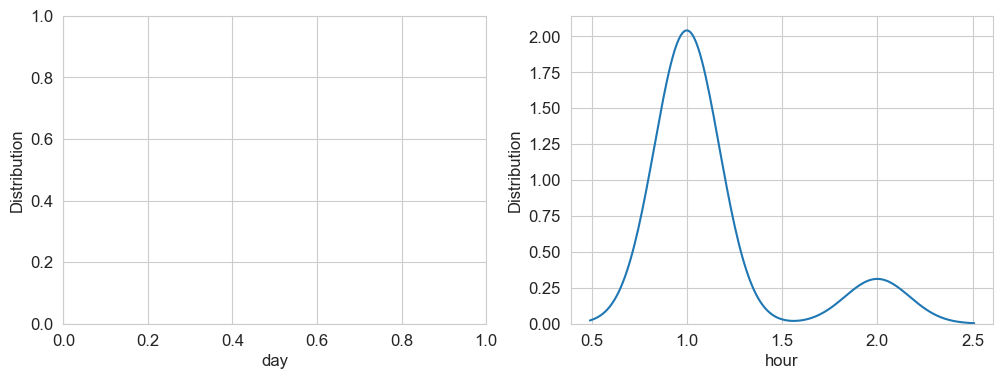

In [30]:
var = ['day','hour']

sns.set_style('whitegrid')

plt.figure()
fig, ax = plt.subplots(1,2,figsize=(12,4))
i = 0
for feature in var:
    i = i + 1
    plt.subplot(1,2,i)
    sns.kdeplot(trainset[feature], bw_method=0.5, label="train", warn_singular=False)
    sns.kdeplot(testset[feature], bw_method=0.5, label="test", warn_singular=False)
    plt.ylabel('Distribution', fontsize=12)
    plt.xlabel(feature, fontsize=12)
    locs, labels = plt.xticks()
    #plt.setp(labels, rotation=90)
    plt.tick_params(axis='both', which='major', labelsize=12)
plt.show();

Let's calculate the derived features as well for the test set.

In [31]:
testset = perform_countuniq( testset, ['ip'], 'channel', 'X0', 'uint8', show_max=True ); gc.collect()
testset = perform_cumcount( testset, ['ip', 'device', 'os'], 'app', 'X1', show_max=True ); gc.collect()
testset = perform_countuniq( testset, ['ip', 'day'], 'hour', 'X2', 'uint8', show_max=True ); gc.collect()
testset = perform_countuniq( testset, ['ip'], 'app', 'X3', 'uint8', show_max=True ); gc.collect()
testset = perform_countuniq( testset, ['ip', 'app'], 'os', 'X4', 'uint8', show_max=True ); gc.collect()
testset = perform_countuniq( testset, ['ip'], 'device', 'X5', 'uint16', show_max=True ); gc.collect()
testset = perform_countuniq( testset, ['app'], 'channel', 'X6', show_max=True ); gc.collect()
testset = perform_cumcount( testset, ['ip'], 'os', 'X7', show_max=True ); gc.collect()
testset = perform_countuniq( testset, ['ip', 'device', 'os'], 'app', 'X8', show_max=True ); gc.collect()
testset = perform_count( testset, ['ip', 'day', 'hour'], 'ip_tcount', show_max=True ); gc.collect()
testset = perform_count( testset, ['ip', 'app'], 'ip_app_count', show_max=True ); gc.collect()
testset = perform_count( testset, ['ip', 'app', 'os'], 'ip_app_os_count', 'uint16', show_max=True ); gc.collect()
testset = perform_var( testset, ['ip', 'day', 'channel'], 'hour', 'ip_tchan_count', show_max=True ); gc.collect()
testset = perform_var( testset, ['ip', 'app', 'os'], 'hour', 'ip_app_os_var', show_max=True ); gc.collect()
testset = perform_var( testset, ['ip', 'app', 'channel'], 'day', 'ip_app_channel_var_day', show_max=True ); gc.collect()
testset = perform_mean( testset, ['ip', 'app', 'channel'], 'hour', 'ip_app_channel_mean_hour', show_max=True ); gc.collect()

Counting unique  channel  by  ['ip'] ...
X0 max value =  87
Cumulative count by  ['ip', 'device', 'os'] ...
X1 max value =  366
Counting unique  hour  by  ['ip', 'day'] ...
X2 max value =  1
Counting unique  app  by  ['ip'] ...
X3 max value =  39
Counting unique  os  by  ['ip', 'app'] ...
X4 max value =  39
Counting unique  device  by  ['ip'] ...
X5 max value =  7
Counting unique  channel  by  ['app'] ...
X6 max value =  33
Cumulative count by  ['ip'] ...
X7 max value =  1581
Counting unique  app  by  ['ip', 'device', 'os'] ...
X8 max value =  26
Aggregating by  ['ip', 'day', 'hour'] ...
ip_tcount max value =  1582
Aggregating by  ['ip', 'app'] ...
ip_app_count max value =  315
Aggregating by  ['ip', 'app', 'os'] ...
ip_app_os_count max value =  96
Calculating variance of  hour  by  ['ip', 'day', 'channel'] ...
ip_tchan_count max value =  0.0
Calculating variance of  hour  by  ['ip', 'app', 'os'] ...
ip_app_os_var max value =  0.0
Calculating variance of  day  by  ['ip', 'app', 'channe

0

<Figure size 640x480 with 0 Axes>

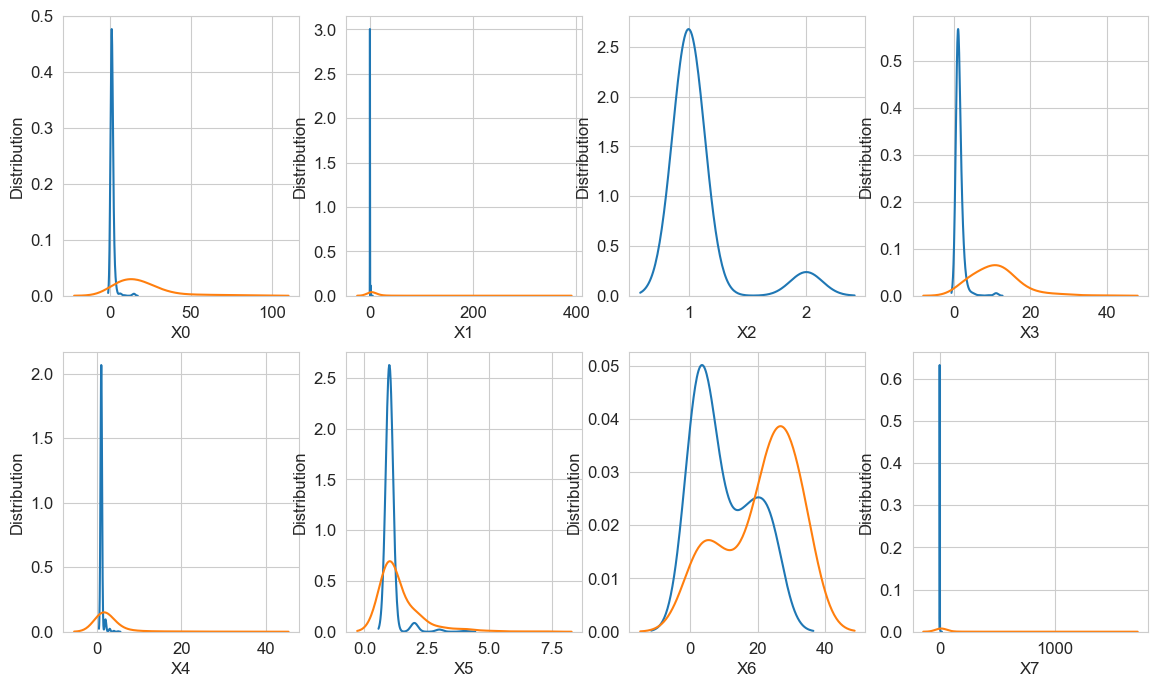

In [32]:
var = ['X0','X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7']

sns.set_style('whitegrid')

plt.figure()
fig, ax = plt.subplots(2,4,figsize=(14,8))
i = 0
for feature in var:
    i = i + 1
    plt.subplot(2,4,i)
    sns.kdeplot(trainset[feature], bw_method=0.5, label="train", warn_singular=False)
    sns.kdeplot(testset[feature], bw_method=0.5, label="test", warn_singular=False)
    plt.ylabel('Distribution', fontsize=12)
    plt.xlabel(feature, fontsize=12)
    locs, labels = plt.xticks()
    #plt.setp(labels, rotation=90)
    plt.tick_params(axis='both', which='major', labelsize=12)
plt.show();

<Figure size 640x480 with 0 Axes>

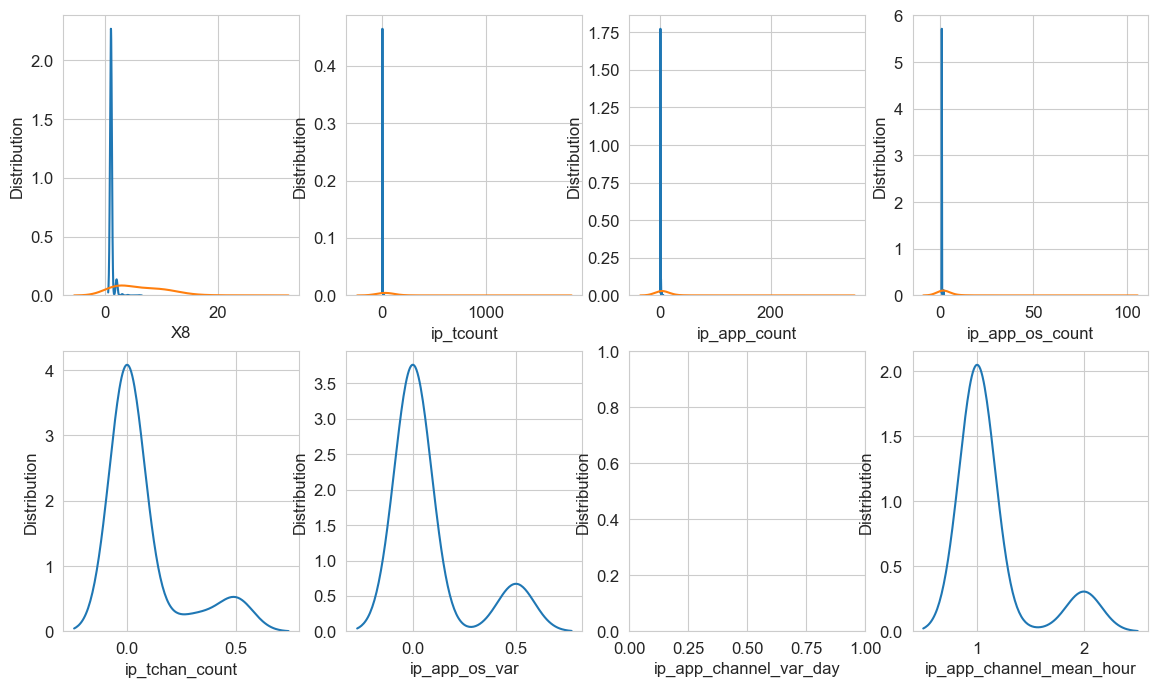

In [33]:
var = ['X8', 'ip_tcount', 'ip_app_count','ip_app_os_count', 
       'ip_tchan_count', 'ip_app_os_var','ip_app_channel_var_day', 'ip_app_channel_mean_hour']

sns.set_style('whitegrid')

plt.figure()
fig, ax = plt.subplots(2,4,figsize=(14,8))
i = 0
for feature in var:
    i = i + 1
    plt.subplot(2,4,i)
    sns.kdeplot(trainset[feature], bw_method=0.5, label="train", warn_singular=False)
    sns.kdeplot(testset[feature], bw_method=0.5, label="test", warn_singular=False)
    plt.ylabel('Distribution', fontsize=12)
    plt.xlabel(feature, fontsize=12)
    locs, labels = plt.xticks()
    #plt.setp(labels, rotation=90)
    plt.tick_params(axis='both', which='major', labelsize=12)
plt.show();

# <a id="7">Model</a>

## <a id="71">Prepare the model</a>

In [34]:
start = datetime.now()

len_train = len(trainset)
gc.collect()
1
most_freq_hours_in_test_data = [1]
least_freq_hours_in_test_data = [2]

def prep_data( df ):
    df = df.copy()
    df['hour'] = pd.to_datetime(df.click_time).dt.hour.astype('uint8')
    df['day'] = pd.to_datetime(df.click_time).dt.day.astype('uint8')
    df.drop(['click_time'], axis=1, inplace=True)
    gc.collect()
    
    df['in_test_hh'] = (   3 
                         - 2*df['hour'].isin(  most_freq_hours_in_test_data ) 
                         - 1*df['hour'].isin( least_freq_hours_in_test_data ) ).astype('uint8')
    gp = df[['ip', 'day', 'in_test_hh', 'channel']].groupby(by=['ip', 'day', 'in_test_hh'])[['channel']].count().reset_index().rename(index=str, columns={'channel': 'nip_day_test_hh'})
    df = df.merge(gp, on=['ip','day','in_test_hh'], how='left')
    df.drop(['in_test_hh'], axis=1, inplace=True)
    df['nip_day_test_hh'] = df['nip_day_test_hh'].astype('uint32')
    del gp
    gc.collect()

    gp = df[['ip', 'day', 'hour', 'channel']].groupby(by=['ip', 'day', 'hour'])[['channel']].count().reset_index().rename(index=str, columns={'channel': 'nip_day_hh'})
    df = df.merge(gp, on=['ip','day','hour'], how='left')
    df['nip_day_hh'] = df['nip_day_hh'].astype('uint16')
    del gp
    gc.collect()
    
    gp = df[['ip', 'os', 'hour', 'channel']].groupby(by=['ip', 'os', 'hour'])[['channel']].count().reset_index().rename(index=str, columns={'channel': 'nip_hh_os'})
    df = df.merge(gp, on=['ip','os','hour'], how='left')
    df['nip_hh_os'] = df['nip_hh_os'].astype('uint16')
    del gp
    gc.collect()

    gp = df[['ip', 'app', 'hour', 'channel']].groupby(by=['ip', 'app',  'hour'])[['channel']].count().reset_index().rename(index=str, columns={'channel': 'nip_hh_app'})
    df = df.merge(gp, on=['ip','app','hour'], how='left')
    df['nip_hh_app'] = df['nip_hh_app'].astype('uint16')
    del gp
    gc.collect()

    gp = df[['ip', 'device', 'hour', 'channel']].groupby(by=['ip', 'device', 'hour'])[['channel']].count().reset_index().rename(index=str, columns={'channel': 'nip_hh_dev'})
    df = df.merge(gp, on=['ip','device','hour'], how='left')
    df['nip_hh_dev'] = df['nip_hh_dev'].astype('uint32')
    del gp
    gc.collect()

    df.drop( ['ip','day'], axis=1, inplace=True )
    gc.collect()
    return df

In [35]:
trainset = prep_data(trainset)
testset = prep_data(testset)

gc.collect()

params = {
          'boosting_type': 'gbdt',
          'objective': 'binary',
          'metric':'auc',
          'learning_rate': 0.1,
          'num_leaves': 90,  # we should let it be smaller than 2^(max_depth)
          'max_depth': 10,  # -1 means no limit
          'min_child_samples': 100,  # Minimum number of data need in a child(min_data_in_leaf)
          'max_bin': 100,  # Number of bucketed bin for feature values
          'subsample': 0.9,  # Subsample ratio of the training instance.
          'subsample_freq': 1,  # frequence of subsample, <=0 means no enable
          'colsample_bytree': 0.7,  # Subsample ratio of columns when constructing each tree.
          'min_child_weight': 0,  # Minimum sum of instance weight(hessian) needed in a child(leaf)
          'min_split_gain': 0,  # lambda_l1, lambda_l2 and min_gain_to_split to regularization
          'nthread': 8,
          'verbose': 0,
          'verbosity': -1,
         }

target = 'is_attributed'
predictors = ['app','device','os', 'channel', 'hour', 'nip_day_test_hh', 'nip_day_hh', 'nip_hh_os', 'nip_hh_app', 'nip_hh_dev']
categorical = ['app', 'device', 'os', 'channel', 'hour']


## <a id="72">Train the model</a>

In [36]:
train_df, val_df = train_test_split(trainset, test_size=VALID_SIZE, random_state=RANDOM_STATE, shuffle=True )
    
dtrain = lgb.Dataset(train_df[predictors].values, 
                     label=train_df[target].values,
                     feature_name=predictors,
                     categorical_feature=categorical)
del train_df
gc.collect()
dvalid = lgb.Dataset(val_df[predictors].values,
                     label=val_df[target].values,
                     feature_name=predictors,
                     categorical_feature=categorical)
del val_df
gc.collect()
model = lgb.train(params, 
                  dtrain, 
                  valid_sets=[dtrain, dvalid], 
                  valid_names=['train','valid'],  
                  num_boost_round=MAX_ROUNDS,
                  feval=None)
del dvalid

# <a id="73">Prediction<a>

In [37]:
test_predictions = model.predict(testset[predictors], num_iteration=model.best_iteration)

threshold = 0.982
testset['predicted_is_attributed'] = (test_predictions >= threshold).astype(int)

comparison_binary = testset[['is_attributed', 'predicted_is_attributed']]

print(comparison_binary.head())

   is_attributed  predicted_is_attributed
0              0                        0
1              0                        0
2              0                        0
3              0                        0
4              1                        0


# <a id="8">Testing<a>

In [38]:
thresholds = [i / 1000 for i in range(900, 1000)]

best_threshold = None
best_f1_score = 0

for threshold in thresholds:
    binary_predictions = (test_predictions >= threshold).astype(int)
    f1 = f1_score(testset['is_attributed'], binary_predictions)
    
    if f1 > best_f1_score:
        best_f1_score = f1
        best_threshold = threshold

print("Optimal Threshold:", best_threshold)
print("Best F1 Score:", best_f1_score)

Optimal Threshold: 0.982
Best F1 Score: 0.5340943226194053


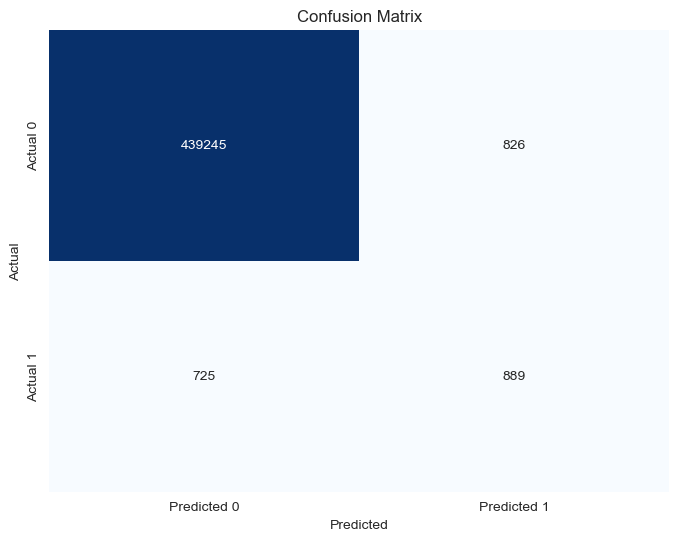

In [39]:
actual_values = comparison_binary['is_attributed']
predicted_values = comparison_binary['predicted_is_attributed']

conf_matrix = confusion_matrix(actual_values, predicted_values)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [40]:
roc_auc = roc_auc_score(actual_values, predicted_values)
print("ROC AUC:", roc_auc)

ROC AUC: 0.7744642412199246
